## Import the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Import the dataset

In [2]:
dataset_filepath = '/Users/davronabdukhakimov/Desktop/RealEstate_California.csv'
raw_dataset = pd.read_csv(dataset_filepath)

# convert 'datePostedString' into column with date dtype
raw_dataset['date_posted'] = pd.to_datetime(raw_dataset['datePostedString'],format='%Y-%m-%d')

## Dealing with missing values

### Analyzing pricePerSquareFoot column

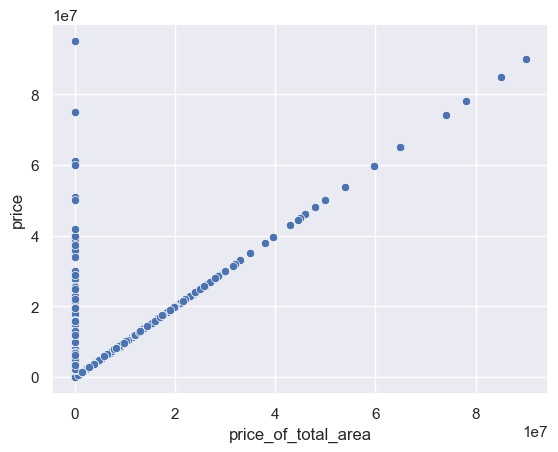

In [3]:
raw_dataset['price_of_total_area'] = raw_dataset['pricePerSquareFoot'] * raw_dataset['livingAreaValue']
sns.scatterplot(x=raw_dataset['price_of_total_area'],y =raw_dataset['price'])

''' from the scatterplot below we can see that multiplying pricePerSquareFoot by livingAreaValue gives the price (target variable)
but we don't know pricePerSquareFoot prior to knowing price value '''
raw_dataset.drop('price_of_total_area',axis=1,inplace=True)

### Drop unnecessary columns

In [4]:
# columns which are redundant
columns_to_drop = ['Unnamed: 0','cityId','id','stateId','currency','countyId','state','country','description',
                   'time','datePostedString','hasBadGeocode','is_bankOwned','is_forAuction','lotAreaUnits',
                  'pricePerSquareFoot','longitude','latitude','event']
clean_dataset = raw_dataset.drop(columns_to_drop,axis = 1)

### Drop rows with nan values, duplicates and rows with event type of rent

In [5]:
print(f"Start: {clean_dataset.shape}")
clean_dataset.dropna(inplace=True)
print(f"After dropna: {clean_dataset.shape}")
clean_dataset.drop_duplicates(inplace=True)
print(f"After dropping duplicates: {clean_dataset.shape}")

print(f"After dropping rent houses: {clean_dataset.shape}")
# only 1 entry for "APARTMENT"
clean_dataset.loc[clean_dataset['homeType'] == 'APARTMENT','homeType'] = 'CONDO'

# some features such as yearBuilt of lot properties are ambiguous 
clean_dataset = clean_dataset[clean_dataset['homeType'] != 'LOT']
clean_dataset = clean_dataset[clean_dataset['homeType'] != 'MULTI_FAMILY']
print(f"After dropping lot houses: {clean_dataset.shape}")

print(f"After dropping pending sale: {clean_dataset.shape}")

Start: (35389, 21)
After dropna: (35360, 21)
After dropping duplicates: (31267, 21)
After dropping rent houses: (31267, 21)
After dropping lot houses: (23432, 21)
After dropping pending sale: (23432, 21)


### Extract season from date_posted column

In [6]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'
    
clean_dataset['season_posted'] = clean_dataset['date_posted'].apply(get_season)
clean_dataset.drop('date_posted',axis=1,inplace=True)

### Extract street name from streetAddress column

In [7]:
split_address = clean_dataset['streetAddress'].str.split(' ',n=1,expand=True)
clean_dataset = clean_dataset[split_address[1].notna()]
clean_dataset = clean_dataset[split_address[0].str.isdigit()]
clean_dataset['street_name'] = split_address[1]
clean_dataset.drop('streetAddress',axis = 1,inplace=True)

/var/folders/r1/m92fhd0n5mq0_bh6sg3_pnlh0000gn/T/ipykernel_14455/2322718560.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_dataset = clean_dataset[split_address[0].str.isdigit()]


### Drop livingArea since the column contains the same values as livingAreaValue column

In [8]:
# there is only 1 entry where livingArea and livingAreaValue have different values
clean_dataset.drop('livingArea',axis=1,inplace=True)

### Copy values from buildingArea to livingAreaValue

In [9]:
print(clean_dataset[(clean_dataset['buildingArea'] != 0) & (clean_dataset['livingAreaValue'] == 0)].shape)
clean_dataset.loc[(clean_dataset['buildingArea'] != 0) & (clean_dataset['livingAreaValue'] == 0), 'livingAreaValue'] = clean_dataset['buildingArea']
clean_dataset.drop('buildingArea',axis=1,inplace=True)

(0, 20)


### Drop hasGarage column since garageSpaces column is more informative

In [10]:
print(f"hasGarage = 1 and garageSpaces = 0: {clean_dataset[(clean_dataset['hasGarage'] == 1) & (clean_dataset['garageSpaces'] == 0)].shape[0]} entries")
print(f"hasGarage = 0 and garageSpaces != 0: {clean_dataset[(clean_dataset['hasGarage'] == 0) & (clean_dataset['garageSpaces'] != 0)].shape[0]} entries")
print(f"parking = 0 and garageSpaces != 0: {clean_dataset[(clean_dataset['parking'] == 0) & (clean_dataset['garageSpaces'] != 0)].shape[0]}")
print(f"parking = 1 and garageSpaces = 0: {clean_dataset[(clean_dataset['parking'] == 1) & (clean_dataset['garageSpaces'] == 0)].shape[0]}")
clean_dataset = clean_dataset[((clean_dataset['hasGarage'] == 0) & (clean_dataset['garageSpaces'] == 0)) | ((clean_dataset['hasGarage'] != 0) & (clean_dataset['garageSpaces'] != 0))]
clean_dataset.drop('hasGarage',axis=1,inplace=True)
print(clean_dataset.shape)

hasGarage = 1 and garageSpaces = 0: 756 entries
hasGarage = 0 and garageSpaces != 0: 87 entries
parking = 0 and garageSpaces != 0: 93
parking = 1 and garageSpaces = 0: 5249
(22414, 18)


### Split levels column into 2 columns (level and multi/split)

In [11]:
zero_level = ['0']
one_level = ['One','One Story','One Story-One','One-Two','1','One-Multi/Split','Other-One','One-Three Or More',
             'One Story-Two','One Story-Three Or More','Multi/Split-One','One-Two-Three Or More','One-Two-Multi/Split']
two_level = ['Two','Two Story','Two Story-Two','2','Two-Multi/Split','Multi/Split-Two','Two-Three Or More','Two Story-One',
             'Two Story-Three Or More','Two-Three Or More-Multi/Split','Two-One']
three_level_more = ['Three Or More','Three or More Stories','Tri-Level','Three or More Stories-Three Or More',
                    'Three Or More-Multi/Split','3','Three','Three or More Stories-One','Three or More Stories-Two',
                   'Four','Tri-Level-Three Or More','Multi/Split-Three Or More','Multi/Split-Tri-Level','4+','Five or More',
                    'Three Or More-Split Level','Tri-Level-Two','Three Or More-Two','Three or More Stories-One-Two']


total = zero_level
total.extend(one_level)
total.extend(two_level)
total.extend(three_level_more)
missing_type = [val for val in clean_dataset['levels'].unique() if val not in total]

def get_level(level):
    if level in one_level:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['one', 1]
        else:
            return ['one', 0]
    elif level in two_level:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['two', 1]
        else:
            return ['two', 0]
    elif level in three_level_more:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['three+', 1]
        else:
            return ['three+', 0]
    else:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['zero', 1]
        else:
            return ['zero', 0]

clean_dataset[['level','multi/split']] = clean_dataset['levels'].apply(lambda x: pd.Series(get_level(x)))
clean_dataset.drop('levels',axis=1,inplace=True)

### Level column represents which floor the house is located for CONDO properties

In [12]:
def get_location_level(type):
    if type == 'CONDO':
        return 1
    else:
        return 0
clean_dataset['is_location_level'] = clean_dataset['homeType'].apply(get_location_level)

### Remove ambiguous yearBuilt values

In [13]:
print(clean_dataset.shape)
# drop rows with value of 0 (missing value) in the yearBuilt column
clean_dataset = clean_dataset[(clean_dataset['yearBuilt'] != 0) & (clean_dataset['yearBuilt'] < 3000)]

(22414, 20)


In [14]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22144 entries, 1 to 35388
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              22144 non-null  float64
 1   city               22144 non-null  object 
 2   yearBuilt          22144 non-null  int64  
 3   zipcode            22144 non-null  float64
 4   livingAreaValue    22144 non-null  float64
 5   bathrooms          22144 non-null  float64
 6   bedrooms           22144 non-null  float64
 7   parking            22144 non-null  int64  
 8   garageSpaces       22144 non-null  float64
 9   pool               22144 non-null  int64  
 10  spa                22144 non-null  int64  
 11  isNewConstruction  22144 non-null  int64  
 12  hasPetsAllowed     22144 non-null  int64  
 13  homeType           22144 non-null  object 
 14  county             22144 non-null  object 
 15  season_posted      22144 non-null  object 
 16  street_name        22144 no

### Remove the outliers

In [15]:
def remove_outliers(df,columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [16]:
print(clean_dataset.shape)
columns_with_outliers = [
    'price','livingAreaValue','bathrooms','bedrooms','garageSpaces'
                    ]
clean_dataset = remove_outliers(clean_dataset,columns_with_outliers)
print(clean_dataset.shape)

(22144, 20)
(18103, 20)


### Create age column

In [17]:
from datetime import datetime
clean_dataset['age'] = datetime.today().year - clean_dataset['yearBuilt']
clean_dataset.drop('yearBuilt',axis=1,inplace=True)

### Visualize relationships between price and features

In [18]:
numerical_columns = ['price','age','zipcode','livingAreaValue']
categorical_columns = [
    'parking','pool','spa','isNewConstruction','hasPetsAllowed','homeType',
    'season_posted','level','multi/split','is_location_level','bathrooms','bedrooms','garageSpaces'
]

In [19]:
import math
def draw_regplots(data,columns):
    n_columns = 4
    n_rows = math.ceil(float(len(columns)) / float(n_columns))
    fig, ax = plt.subplots(n_rows,n_columns,figsize = (50,20))
    x = 0
    y = 0
    for column in columns:
        sns.regplot(x=data[column],y=data['price'],ax=ax[y])
        y += 1
        if y == n_columns:
            y = 0
            x += 1

In [20]:
def draw_boxplots(data,columns):
    n_columns = 4
    n_rows = math.ceil(float(len(columns)) / float(n_columns))
    fig, ax = plt.subplots(n_rows,n_columns,figsize = (50,30))
    x = 0
    y = 0
    for column in columns:
        sns.boxplot(x=data[column],y=data['price'],ax=ax[x,y])
        y += 1
        if y == n_columns:
            y = 0
            x += 1

In [21]:
def draw_histplots(data,columns):
    n_columns = 4
    n_rows = math.ceil(float(len(columns)) / float(n_columns))
    fig, ax = plt.subplots(n_rows,n_columns,figsize = (50,20))
    x = 0
    y = 0
    for column in columns:
        sns.histplot(x=data[column],ax=ax[y])
        y += 1
        if y == n_columns:
            y = 0
            x += 1

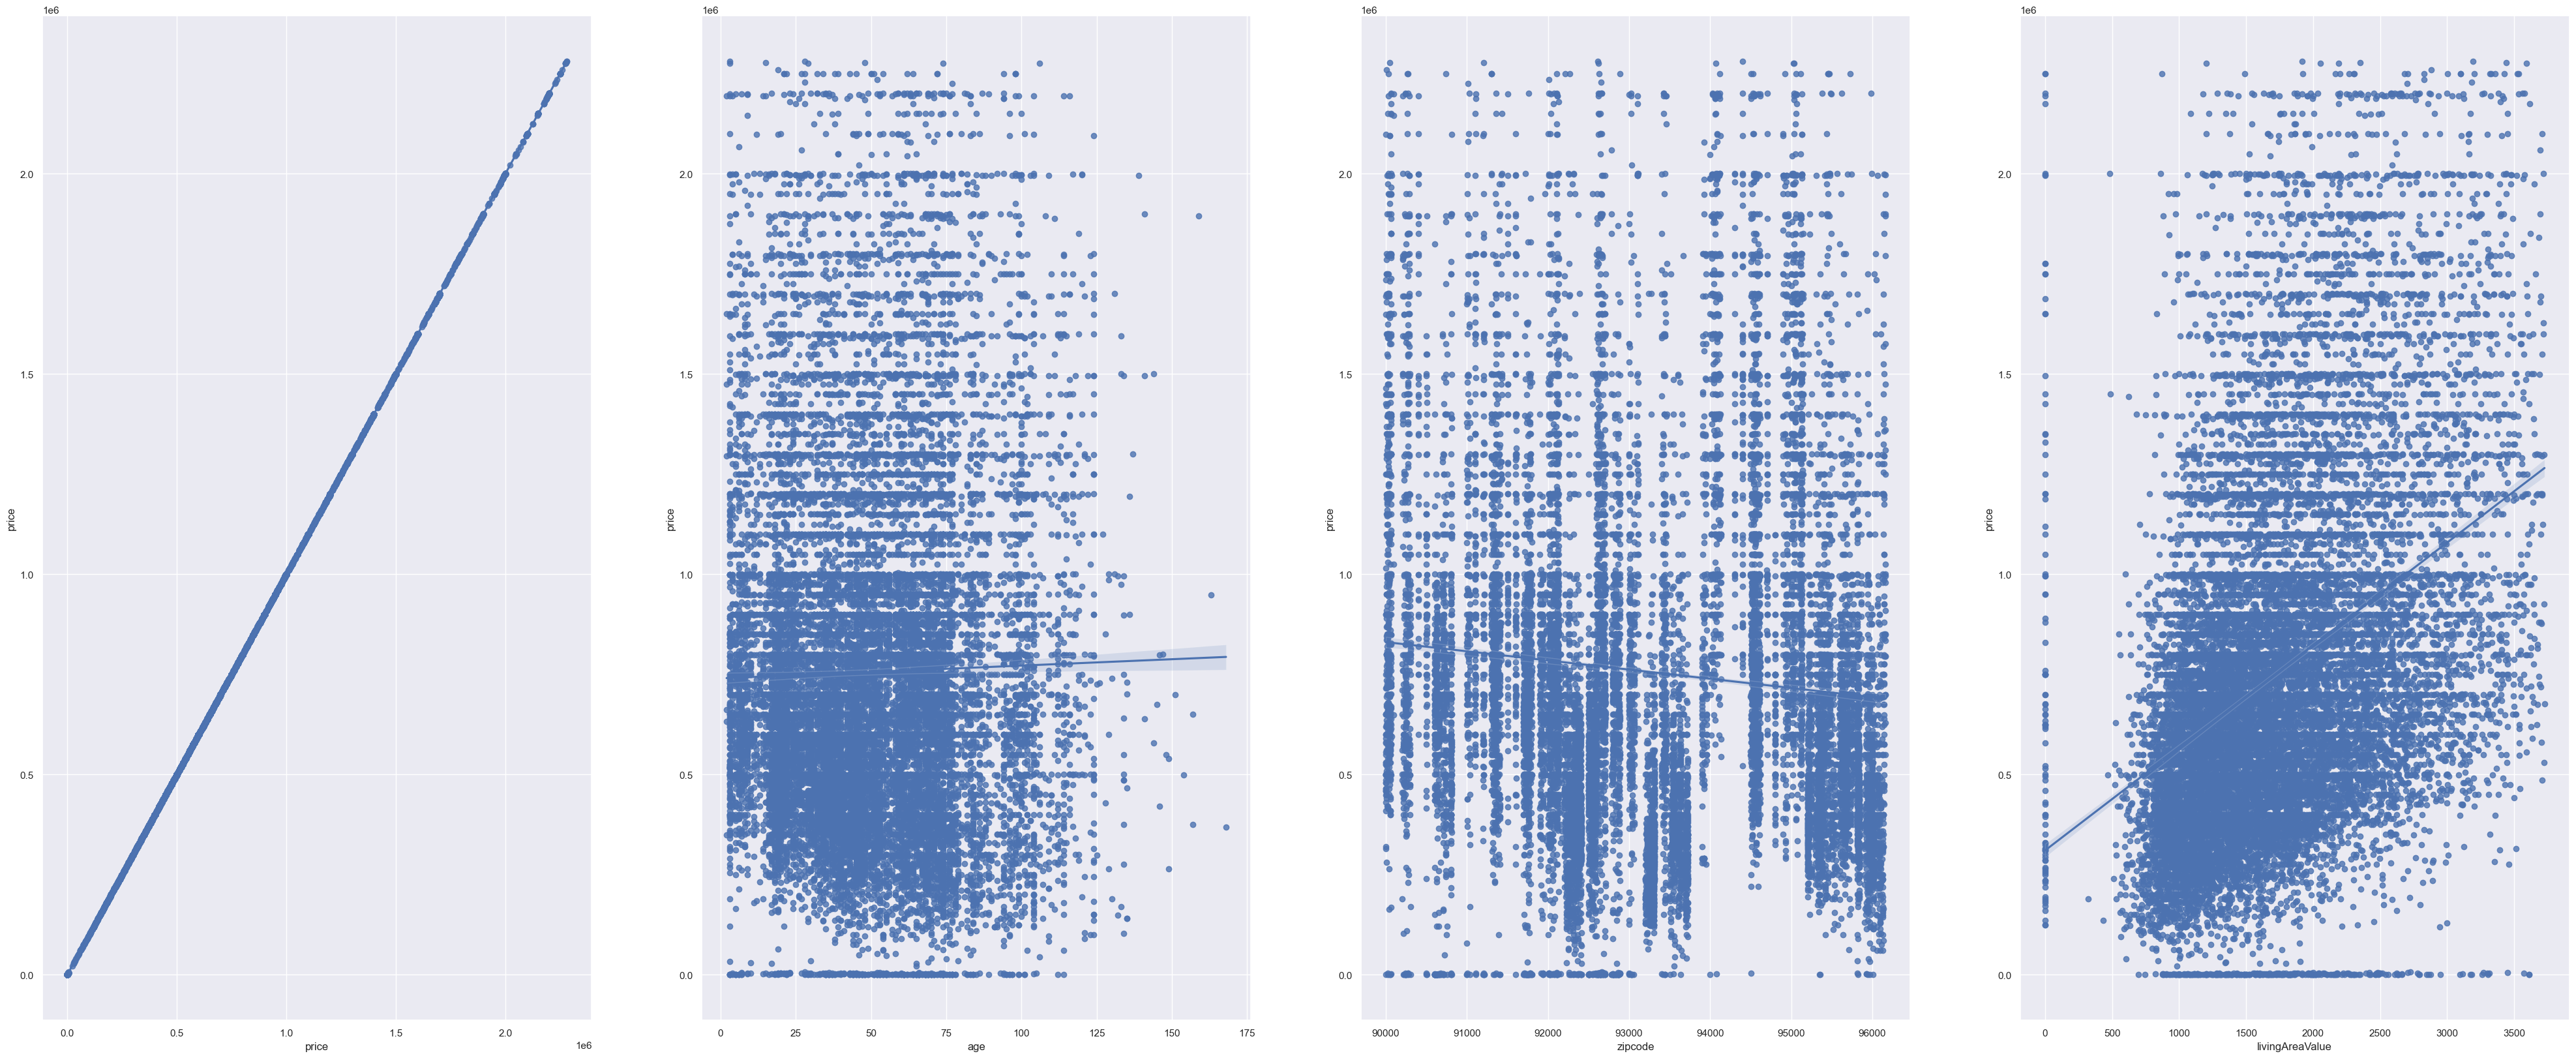

In [22]:
draw_regplots(clean_dataset,numerical_columns)

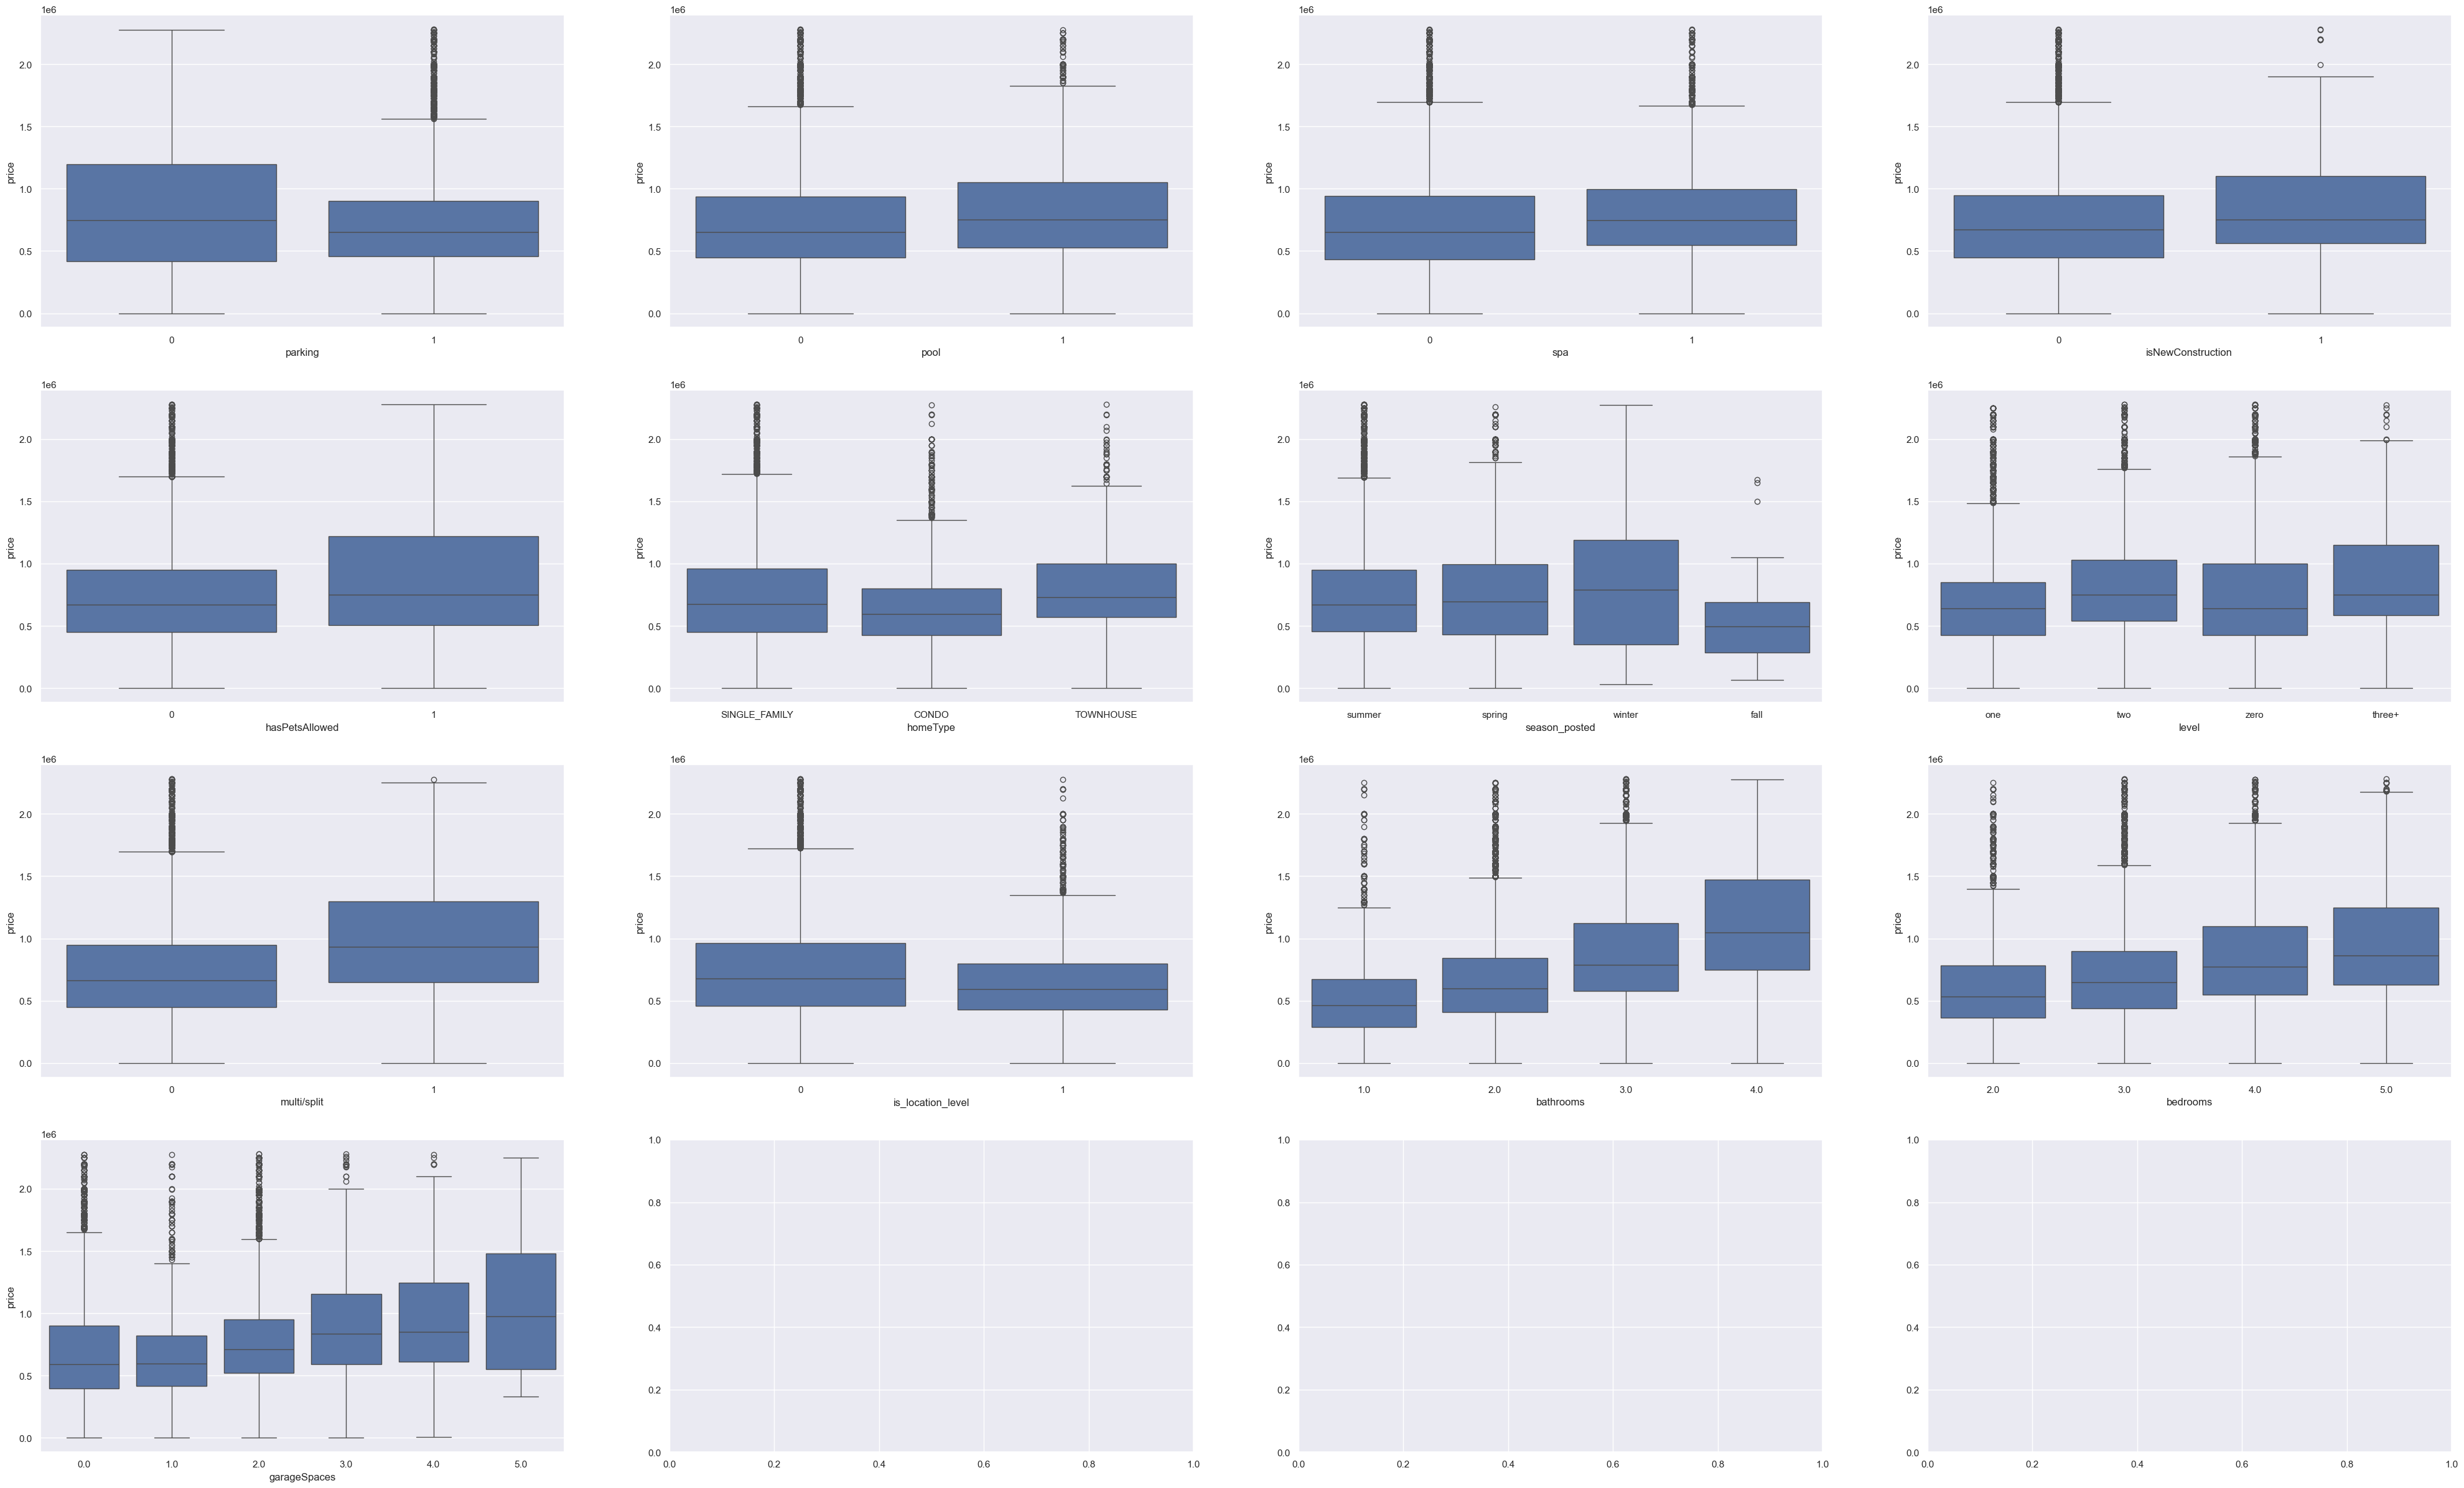

In [23]:
draw_boxplots(clean_dataset,categorical_columns)

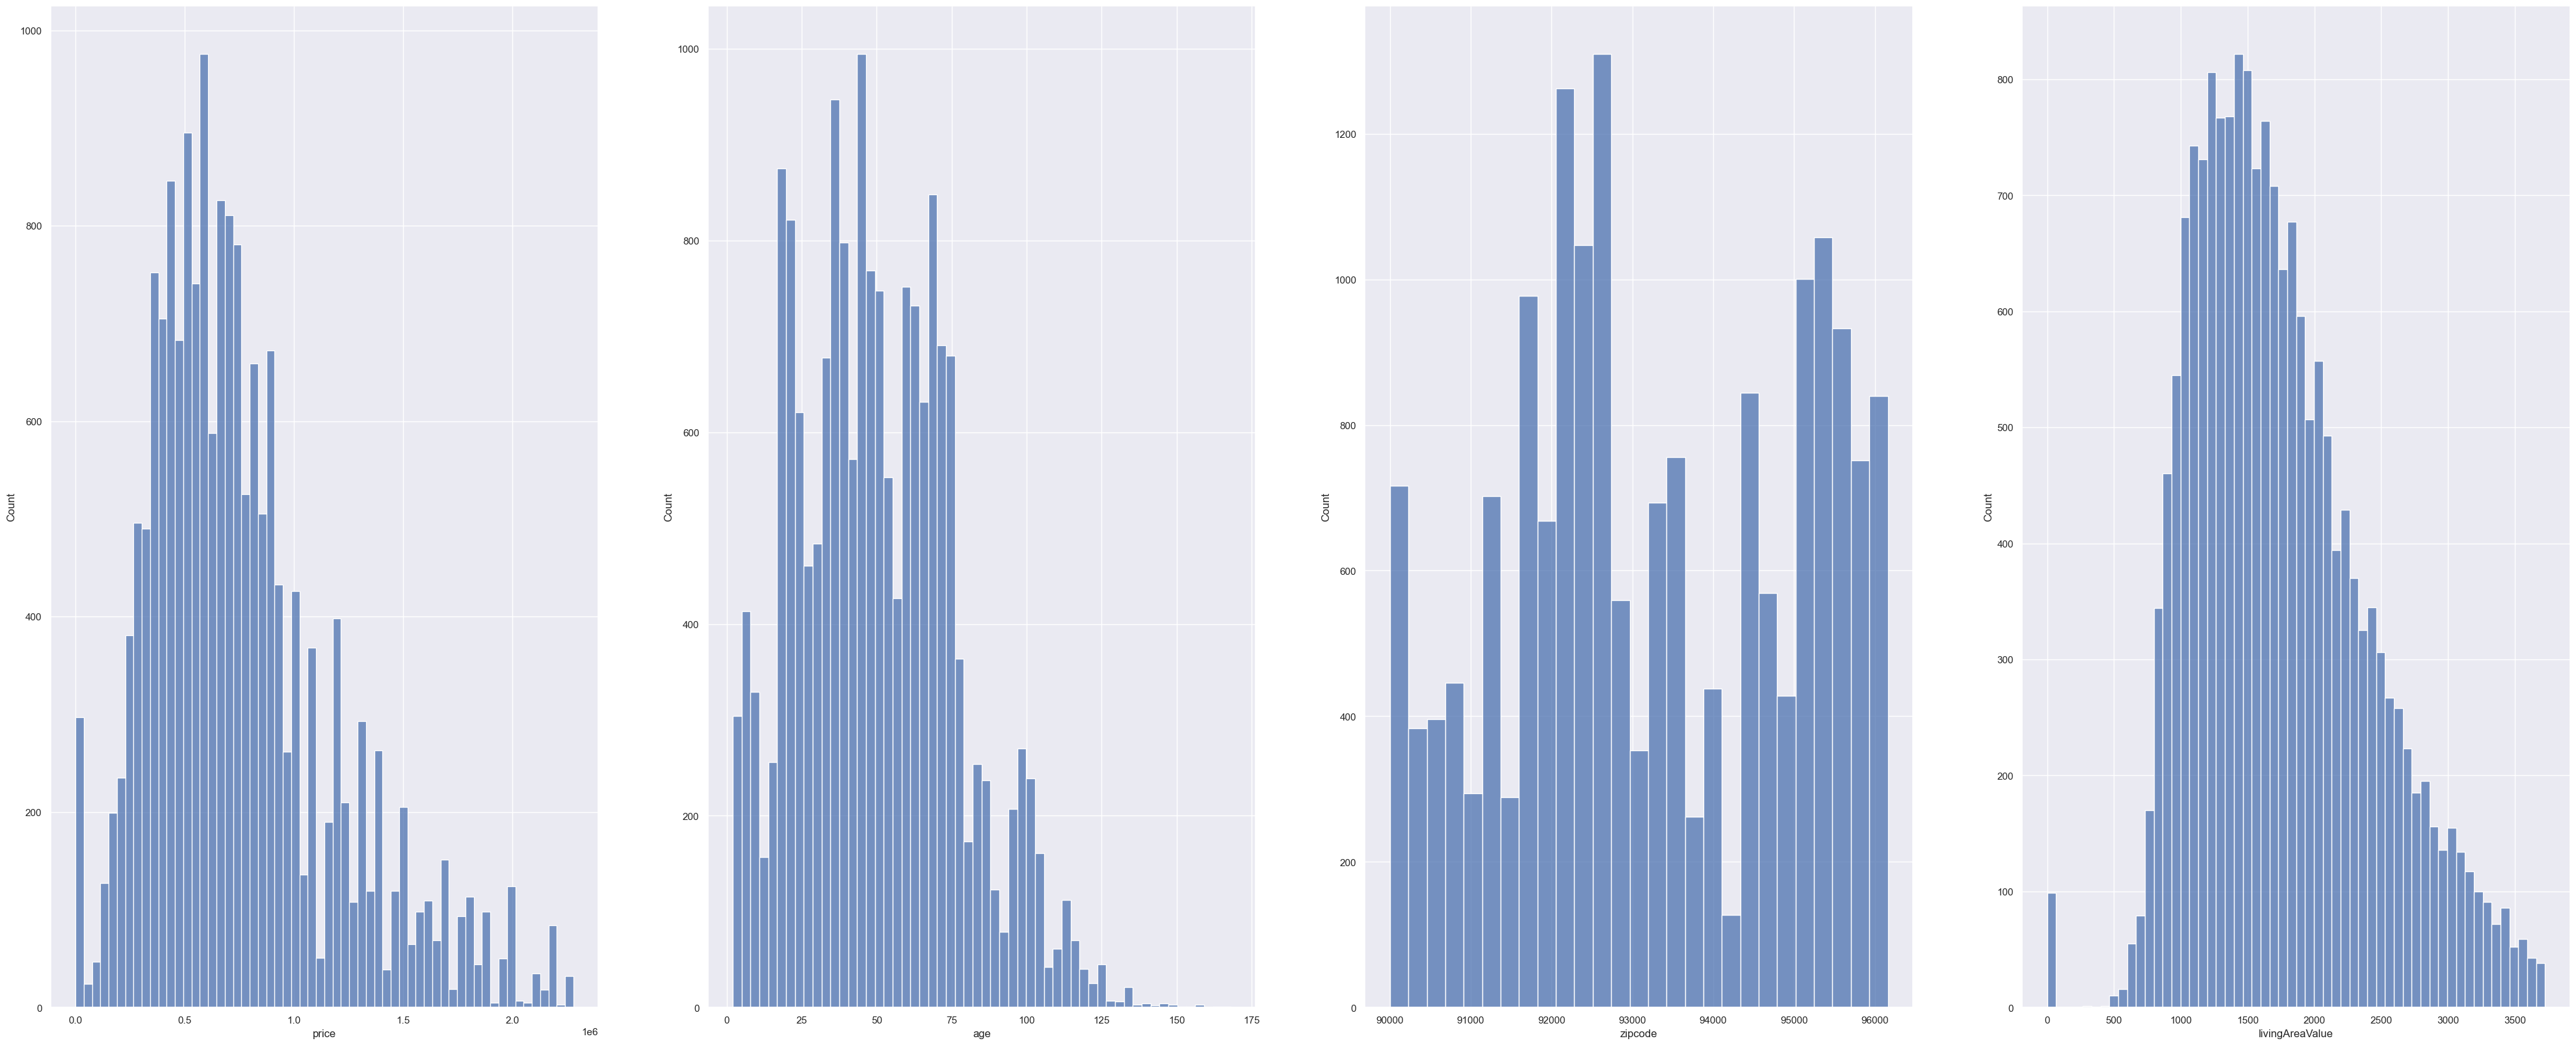

In [24]:
draw_histplots(clean_dataset,numerical_columns)

In [25]:
# value_counts of categorical columns
for col in categorical_columns:
    print(clean_dataset[col].value_counts())
    print('==================================')

parking
1    14856
0     3247
Name: count, dtype: int64
pool
0    15866
1     2237
Name: count, dtype: int64
spa
0    14607
1     3496
Name: count, dtype: int64
isNewConstruction
0    17909
1      194
Name: count, dtype: int64
hasPetsAllowed
0    17805
1      298
Name: count, dtype: int64
homeType
SINGLE_FAMILY    15170
CONDO             2050
TOWNHOUSE          883
Name: count, dtype: int64
season_posted
summer    16360
spring     1621
winter       94
fall         28
Name: count, dtype: int64
level
one       6961
zero      6297
two       4243
three+     602
Name: count, dtype: int64
multi/split
0    17799
1      304
Name: count, dtype: int64
is_location_level
0    16053
1     2050
Name: count, dtype: int64
bathrooms
2.0    8479
3.0    6291
1.0    2249
4.0    1084
Name: count, dtype: int64
bedrooms
3.0    8273
4.0    4940
2.0    3788
5.0    1102
Name: count, dtype: int64
garageSpaces
2.0    8097
0.0    7142
1.0    1460
3.0    1246
4.0     138
5.0      20
Name: count, dtype: int64


In [26]:
for home_type in clean_dataset['homeType'].unique():
    print(home_type)
    print(clean_dataset[clean_dataset['homeType'] == home_type]['multi/split'].value_counts())

SINGLE_FAMILY
multi/split
0    14940
1      230
Name: count, dtype: int64
CONDO
multi/split
0    2012
1      38
Name: count, dtype: int64
TOWNHOUSE
multi/split
0    847
1     36
Name: count, dtype: int64


### One-hot encoding

In [27]:
one_hot_columns = []
ordinal_columns = []
for column in clean_dataset.columns:
    if clean_dataset[column].dtype == 'object':
        if clean_dataset[column].nunique() <= 10:
            one_hot_columns.append(column)
        else:
            ordinal_columns.append(column)
print(f'Columns which we can apply one hot encoding: {one_hot_columns}')
print(f'Columns which we cannot apply one hot encoding: {ordinal_columns}')

Columns which we can apply one hot encoding: ['homeType', 'season_posted', 'level']
Columns which we cannot apply one hot encoding: ['city', 'county', 'street_name']


In [28]:
clean_dataset = pd.get_dummies(data = clean_dataset,
                               columns = one_hot_columns,
                               drop_first = True,
                               dtype = int)
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18103 entries, 1 to 35385
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   18103 non-null  float64
 1   city                    18103 non-null  object 
 2   zipcode                 18103 non-null  float64
 3   livingAreaValue         18103 non-null  float64
 4   bathrooms               18103 non-null  float64
 5   bedrooms                18103 non-null  float64
 6   parking                 18103 non-null  int64  
 7   garageSpaces            18103 non-null  float64
 8   pool                    18103 non-null  int64  
 9   spa                     18103 non-null  int64  
 10  isNewConstruction       18103 non-null  int64  
 11  hasPetsAllowed          18103 non-null  int64  
 12  county                  18103 non-null  object 
 13  street_name             18103 non-null  object 
 14  multi/split             18103 non-null  int

### Group age column

In [29]:
def group_ages(age):
    if age < 6:
        return 1
    elif age < 16:
        return 2
    elif age < 31:
        return 3
    elif age < 51:
        return 4
    else:
        return 5

clean_dataset['age_group'] = clean_dataset['age'].apply(group_ages)
clean_dataset.drop('age',axis=1,inplace=True)

In [30]:
clean_dataset['age_group'].value_counts()

age_group
5    8408
4    5136
3    3219
2     920
1     420
Name: count, dtype: int64

### Group livingAreaValue column

In [31]:
def group_area(area):
    if area < 1001:
        return 1
    elif area < 2001:
        return 2
    elif area < 3001:
        return 3
    else:
        return 4

clean_dataset['area_group'] = clean_dataset['livingAreaValue'].apply(group_area)
clean_dataset.drop('livingAreaValue',axis=1,inplace=True)

In [32]:
clean_dataset['area_group'].value_counts()

area_group
2    10734
3     4613
1     1841
4      915
Name: count, dtype: int64

In [33]:
clean_dataset['county'].value_counts()[-10:]

county
Kings County       30
Mono County        27
Lassen County      26
Mariposa County    25
Glenn County       21
Modoc County       20
Inyo County        10
Sierra County       9
Alpine County       7
Colusa County       4
Name: count, dtype: int64

In [34]:
clean_dataset['city'].value_counts()[-10:]

city
Dorris            1
Catheys Valley    1
Earp              1
Petrolia          1
Ave               1
Round Mountain    1
Wallace           1
Eagle Rock        1
"ONeals"          1
Anaheim Hills     1
Name: count, dtype: int64

In [35]:
clean_dataset['street_name'].value_counts()[-10:]

street_name
Vallejo St           1
Magowan Dr           1
Golf View Ct         1
Hahman Dr            1
E Mall St            1
Voyager Dr           1
Saint James #84      1
Mayten Ave           1
Deerfield Ave #19    1
S Ogden Dr           1
Name: count, dtype: int64

In [36]:
clean_dataset.drop(['city','street_name'],axis=1,inplace=True)

In [37]:
clean_dataset['county'].nunique()

58

In [38]:
clean_dataset['county'].unique()

array(['Contra Costa County', 'Los Angeles County', 'Santa Clara County',
       'Monterey County', 'San Diego County', 'Stanislaus County',
       'Kern County', 'Sacramento County', 'San Mateo County',
       'Shasta County', 'El Dorado County', 'Placer County',
       'Tehama County', 'Tulare County', 'Yolo County',
       'Santa Barbara County', 'San Bernardino County', 'Yuba County',
       'Orange County', 'Sonoma County', 'Humboldt County',
       'San Francisco County', 'Alameda County', 'Riverside County',
       'Santa Cruz County', 'Fresno County', 'Marin County',
       'Imperial County', 'Ventura County', 'Amador County',
       'Mendocino County', 'Sierra County', 'Calaveras County',
       'San Joaquin County', 'Butte County', 'Madera County',
       'Tuolumne County', 'Lake County', 'Nevada County',
       'San Luis Obispo County', 'Mariposa County', 'Kings County',
       'San Benito County', 'Sutter County', 'Merced County',
       'Napa County', 'Solano County', 'Tri

### Label encoding county column

58


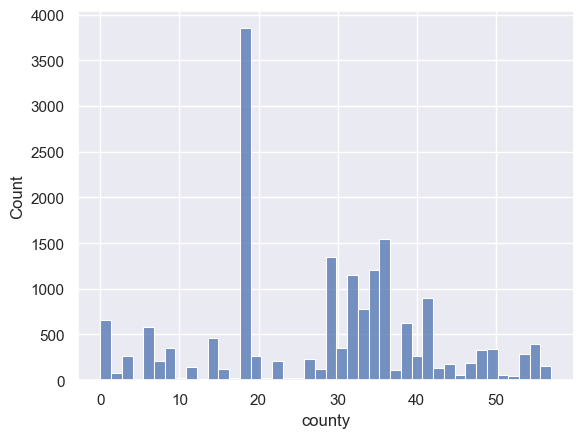

In [39]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
clean_dataset['county'] = label_encoder.fit_transform(clean_dataset['county'])
sns.histplot(clean_dataset['county'])
print(clean_dataset['county'].nunique())

In [40]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18103 entries, 1 to 35385
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   18103 non-null  float64
 1   zipcode                 18103 non-null  float64
 2   bathrooms               18103 non-null  float64
 3   bedrooms                18103 non-null  float64
 4   parking                 18103 non-null  int64  
 5   garageSpaces            18103 non-null  float64
 6   pool                    18103 non-null  int64  
 7   spa                     18103 non-null  int64  
 8   isNewConstruction       18103 non-null  int64  
 9   hasPetsAllowed          18103 non-null  int64  
 10  county                  18103 non-null  int64  
 11  multi/split             18103 non-null  int64  
 12  is_location_level       18103 non-null  int64  
 13  homeType_SINGLE_FAMILY  18103 non-null  int64  
 14  homeType_TOWNHOUSE      18103 non-null  int

In [41]:
from sklearn.model_selection import train_test_split

X = clean_dataset.drop('price',axis=1)
y = clean_dataset['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train = X_train.values
X_test = X_test.values

log_y_train = np.log1p(y_train)

### Model selection

In [42]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import GradientBoostingRegressor


model_names = ['Linear Regression','SVR (rbf)','Decision Tree','Random Forest','Gradient Boosting Regressor','XGBoost']
#model_names = ['Random Forest','XGBoost']
models = [LinearRegression(), SVR(kernel='rbf'),DecisionTreeRegressor(random_state = 0),RandomForestRegressor(random_state = 0),GradientBoostingRegressor(random_state=0),XGBRegressor(random_state = 0)]
#models = [RandomForestRegressor(random_state = 0), XGBRegressor(random_state = 0)]
scoring_metrics = ['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'r2']

In [43]:
def model_performance_table():
    
    unscaled_table = pd.DataFrame({'Model': model_names})
    scaled_table = pd.DataFrame({'Model': model_names})
    
    for metric in scoring_metrics:
        mean_scores = []
        for model in models:
            model_pipeline = Pipeline(
            steps = [
                ('model', model)
                ]
            )
            if metric == 'r2':
                scores =  cross_val_score(model_pipeline,X_train,log_y_train,scoring=metric,cv=5)
            else:
                scores =  -1 * cross_val_score(model_pipeline,X_train,log_y_train,scoring=metric,cv=5)
            mean_scores.append(scores.mean())
        unscaled_table[metric] = mean_scores

    for metric in scoring_metrics:
        mean_scores = []
        for model in models:
            model_pipeline = Pipeline(
            steps = [
                ('scaler', StandardScaler()),
                ('model', model)
                ]
            ) 
            if metric == 'r2':
                scores =  cross_val_score(model_pipeline,X_train,log_y_train,scoring=metric,cv=5)
            else:
                scores =  -1 * cross_val_score(model_pipeline,X_train,log_y_train,scoring=metric,cv=5)
            mean_scores.append(scores.mean())
        scaled_table[metric] = mean_scores
    
    return unscaled_table, scaled_table
    

### Unscaled result

In [44]:
unscaled_result, scaled_result = model_performance_table()
unscaled_result

,Model,neg_root_mean_squared_error,neg_mean_absolute_error,r2
0,Linear Regression,1.506248,0.593304,0.035833
1,SVR (rbf),1.548323,0.598382,-0.018856
2,Decision Tree,2.167927,0.661374,-1.012867
3,Random Forest,1.634160,0.552696,-0.137733
4,Gradient Boosting Regressor,1.472055,0.507744,0.079610
5,XGBoost,1.582729,0.556583,-0.065691


### Scaled table

In [45]:
scaled_result

,Model,neg_root_mean_squared_error,neg_mean_absolute_error,r2
0,Linear Regression,1.506256,0.593350,0.035823
1,SVR (rbf),1.510739,0.489966,0.030424
2,Decision Tree,2.169153,0.662410,-1.014850
3,Random Forest,1.634397,0.552868,-0.138108
4,Gradient Boosting Regressor,1.471529,0.507521,0.080205
5,XGBoost,1.582729,0.556583,-0.065691


### Model tuning

In [49]:
from sklearn.model_selection import GridSearchCV

selected_model = GradientBoostingRegressor()

parameters_of_gradient_boosting = {
    'learning_rate': np.arange(0.1,0.3,0.01),
    'n_estimators': np.arange(90,150,10),
    'max_depth': [3],
    'random_state': [0]
}

grid_search = GridSearchCV(
    estimator=selected_model,
    param_grid=parameters_of_gradient_boosting,
    scoring = 'neg_root_mean_squared_error',
    n_jobs=-1,
    cv=5
)
# grid_search.fit(X_train,log_y_train)
# print(f"Best score: {grid_search.best_score_}")
# print(f"Best parameters: {grid_search.best_params_}")

Best score: -1.4705396766765262
Best parameters: {'learning_rate': 0.11, 'max_depth': 3, 'n_estimators': 90, 'random_state': 0}


### Final model

In [50]:
final_model = GradientBoostingRegressor(learning_rate = 0.11, n_estimators = 90, max_depth = 3, random_state = 0)

final_model.fit(X_train,log_y_train)

GradientBoostingRegressor(learning_rate=0.11, n_estimators=90, random_state=0)

### Testing on train set

In [51]:
def testing_on_train_data(scoring_type, multiplier):
    print(f"================ {scoring_type} =====================")
    
    scores =  multiplier * cross_val_score(final_model,X_train,log_y_train,scoring=scoring_type,cv=10)
    mean_score = scores.mean()
    std_score = scores.std()

    print(f"Mean: {mean_score}")
    print(f"Std: {std_score}")

In [52]:
testing_on_train_data(scoring_type = 'neg_root_mean_squared_error', multiplier = -1)
testing_on_train_data(scoring_type = 'neg_mean_absolute_error', multiplier = -1)
testing_on_train_data(scoring_type = 'r2', multiplier = 1)

================ neg_root_mean_squared_error =====================
Mean: 1.4695954633414854
Std: 0.12638334948515237
================ neg_mean_absolute_error =====================
Mean: 0.5061006722139031
Std: 0.025901812545920236
================ r2 =====================
Mean: 0.08144285079888493
Std: 0.019917826288568752


### Testing on the test set

In [53]:
from sklearn.metrics import r2_score,mean_absolute_error,root_mean_squared_error

def evaluate_model_on_test_set(model,X_test,y_test):
    
    y_pred = np.expm1(model.predict(X_test))
    
    rmse = root_mean_squared_error(y_true=y_test,y_pred=y_pred)
    mae = mean_absolute_error(y_true=y_test,y_pred=y_pred)
    r2 = r2_score(y_true=y_test,y_pred=y_pred)

    print(f"Test RMSE: {rmse}")
    print(f"Test MAE: {mae}")
    print(f"Test R2: {r2}")

In [54]:
evaluate_model_on_test_set(final_model, X_test, y_test)

Test RMSE: 369074.07042944734
Test MAE: 253082.59576679702
Test R2: 0.299100556924878


### ANN

In [496]:
# scaler_X = StandardScaler()
# scaler_y = StandardScaler()

# X_val_ann = X_train.sample(frac=0.2,random_state = 0)
# X_train_ann = X_train.drop(X_val_ann.index)

# y_val_ann = y_train[X_val_ann.index]
# y_train_ann = y_train[X_train_ann.index]

# X_train_scaled = scaler_X.fit_transform(X_train_ann)
# X_val_scaled = scaler_X.transform(X_val_ann)

# y_train_scaled = scaler_y.fit_transform(y_train_ann.values.reshape(-1,1))
# y_val_scaled = scaler_y.transform(y_val_ann.values.reshape(-1,1))

In [497]:
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow.keras.backend as K

# def r2_keras(y_true, y_pred):
#     SS_res = K.sum(K.square(y_true - y_pred))  # Residual sum of squares
#     SS_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
#     return 1 - SS_res / (SS_tot + K.epsilon())  # Adding epsilon to avoid division by zero

# early_stopping = keras.callbacks.EarlyStopping(
#     patience=10,
#     min_delta=0.01,
#     restore_best_weights=True
# )

# ann = keras.Sequential(
#     [
#         layers.InputLayer(input_shape=X.shape[1]),
        
#         #layers.Dropout(rate = 0.3),
#         layers.Dense(units = 10, activation = 'relu'),

#         #layers.BatchNormalization(),
#         #layers.Dropout(rate = 0.3),
#         layers.Dense(units = 10, activation = 'relu'),

#         #layers.BatchNormalization(),
#         #layers.Dropout(rate = 0.3),
#         layers.Dense(units = 10, activation = 'relu'),

#         layers.Dense(units = 1)
#     ]
# )

# ann.compile(
#     loss = 'mean_squared_error',
#     optimizer='adam',
#     metrics = ['mae',r2_keras]
# )

# # history = ann.fit(
# #     X_train_scaled, y_train_scaled,
# #     validation_data=(X_val_scaled, y_val_scaled),
# #     batch_size = 64,
# #     epochs = 50,
# #     callbacks = [early_stopping]
# # )

In [498]:
# history_df = pd.DataFrame(history.history)
# # Start the plot at epoch 5
# history_df.loc[:, ['loss', 'val_loss']].plot()

In [499]:
# X_test_scaled = scaler_X.transform(X_test)

In [500]:
# predictions = scaler_y.inverse_transform(ann.predict(X_test_scaled)) 

# ann_rmse_score = root_mean_squared_error(y_true=y_test,y_pred=predictions)
# ann_mae_score = mean_absolute_error(y_true=y_test,y_pred=predictions)
# ann_r2_score = r2_score(y_true=y_test,y_pred=predictions)

# print(f"ANN RMSE score: {ann_rmse_score}")
# print(f"ANN MAE score: {ann_mae_score}")
# print(f"ANN R2 score: {ann_r2_score}")

In [55]:
import pickle

model_file_path = '/Users/davronabdukhakimov/Desktop/SDS-CP006-california-housing-prediction/web-app/davron_web_app/' + 'davron_model'

with open(model_file_path, 'wb') as write_file:
    pickle.dump(final_model, write_file)

In [56]:
county_encoder_file_path = '/Users/davronabdukhakimov/Desktop/SDS-CP006-california-housing-prediction/web-app/davron_web_app/' + 'davron_county_encoder'

with open(county_encoder_file_path, 'wb') as write_file:
    pickle.dump(label_encoder, write_file)